## 1.- Exploración de datos

In [2]:
# Importa librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

In [3]:
# Función para cargar datos con manejo de errores
def load_data(file_name):
    file_path = f"files/datasets/input/{file_name}"
    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        return data
    except Exception as e:
        print(f"Error: File {file_path} not found.")
        return None

# Carga los datos
contract_data = load_data('contract.csv')
personal_data = load_data('personal.csv')
internet_data = load_data('internet.csv')
phone_data = load_data('phone.csv')

Data loaded successfully from files/datasets/input/contract.csv
Data loaded successfully from files/datasets/input/personal.csv
Data loaded successfully from files/datasets/input/internet.csv
Data loaded successfully from files/datasets/input/phone.csv


In [4]:
# Verifica si los datos se cargaron correctamente
if contract_data is not None and personal_data is not None and internet_data is not None and phone_data is not None:
    # Une los datos en un solo DataFrame
    merged_data = pd.merge(contract_data, personal_data, on='customerID', how='inner')
    merged_data = pd.merge(merged_data, internet_data, on='customerID', how='left')
    merged_data = pd.merge(merged_data, phone_data, on='customerID', how='left')

In [5]:
# Muestra información sobre los datos cargados
display(merged_data.info)

<bound method DataFrame.info of       customerID   BeginDate              EndDate            Type  \
0     7590-VHVEG  2020-01-01                   No  Month-to-month   
1     5575-GNVDE  2017-04-01                   No        One year   
2     3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW  2016-05-01                   No        One year   
4     9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...         ...                  ...             ...   
7038  6840-RESVB  2018-02-01                   No        One year   
7039  2234-XADUH  2014-02-01                   No        One year   
7040  4801-JZAZL  2019-03-01                   No  Month-to-month   
7041  8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK  2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0                 Yes           Electronic check          

In [6]:
# Visualiza una muestra del DataFrame merged_data
display(merged_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


En esta primera sección, se importan las bibliotecas necesarias y se define una función para cargar los datos desde archivos CSV. Después, se cargan los datos de diferentes archivos y se fusionan en un solo DataFrame. Se identifica que esta sección se centra en la preparación inicial de los datos para su análisis subsiguiente.

## 2.- Preprocesamiento de datos

In [7]:
# Manejo de fechas

# Reemplazar los valores 'No' en 'EndDate' con la fecha de hoy
today = pd.Timestamp('today').normalize()
merged_data.loc[merged_data['EndDate'] == 'No', 'EndDate'] = today

# Rellena valores NaN en 'EndDate' con la fecha de hoy
merged_data['EndDate'] = merged_data['EndDate'].fillna(today)

In [8]:
# Convierte 'EndDate' a datetime
merged_data['EndDate'] = pd.to_datetime(merged_data['EndDate'])

# Convierte 'BeginDate' a datetime
merged_data['BeginDate'] = pd.to_datetime(merged_data['BeginDate'])

merged_data['ContractDuration'] = (merged_data['EndDate'] - merged_data['BeginDate']).dt.days / 30


In [9]:
# Crea una nueva columna 'Churn' indicando si el cliente ha cancelado o no
merged_data['Churn'] = (pd.to_datetime(merged_data['EndDate']).dt.normalize() < today).astype(int)

# Reorganiza las columnas para que 'Churn' sea la cuarta columna
columns = list(merged_data.columns)
columns.remove('Churn')
columns.insert(3, 'Churn')
merged_data = merged_data[columns]

In [10]:
# Manejo de valores faltantes

# Rellena valores faltantes en 'MultipleLines' con 'No'
merged_data['MultipleLines'] = merged_data['MultipleLines'].fillna('No') 

# Convierte a numérico y manejar errores
merged_data['TotalCharges'] = pd.to_numeric(merged_data['TotalCharges'], errors='coerce')  

# Rellena valores NaN con 0
merged_data['TotalCharges'] = merged_data['TotalCharges'].fillna(0) 

In [11]:
# Modifica la columna 'SeniorCitizen' para que en lugar de 0 y 1 sea 'No' o 'Yes'
merged_data['SeniorCitizen'] = merged_data['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [12]:
# Visualiza una muestra del DataFrame merged_data
display(merged_data.head())

,customerID,BeginDate,EndDate,Churn,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration
0,7590-VHVEG,2020-01-01,2024-05-11,0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,...,No,DSL,No,Yes,No,No,No,No,No,53.066667
1,5575-GNVDE,2017-04-01,2024-05-11,0,One year,No,Mailed check,56.95,1889.50,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,86.566667
2,3668-QPYBK,2019-10-01,2019-12-01,1,Month-to-month,Yes,Mailed check,53.85,108.15,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,2.033333
3,7795-CFOCW,2016-05-01,2024-05-11,0,One year,No,Bank transfer (automatic),42.30,1840.75,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,No,97.733333
4,9237-HQITU,2019-09-01,2019-11-01,1,Month-to-month,Yes,Electronic check,70.70,151.65,Female,...,No,Fiber optic,No,No,No,No,No,No,No,2.033333


En esta sección, se realizan diversas operaciones para limpiar y estructurar los datos. Aquí se manejan las fechas, se trata la presencia de valores faltantes y se ajustan algunas representaciones de datos. Esto incluye el reemplazo de valores 'No' en 'EndDate' con la fecha actual, el cálculo de la duración del contrato y la conversión de la representación de la columna 'SeniorCitizen'. Esta sección se dedica a garantizar que los datos estén listos para el análisis exploratorio.

## 3.- Análisis exploratorio de datos (EDA)

In [13]:
# Estadísticas descriptivas para características numéricas
print("\nEstadísticas descriptivas para características numéricas:")
print(merged_data.describe())


Estadísticas descriptivas para características numéricas:
                           BeginDate                        EndDate  \
count                           7043                           7043   
mean   2017-04-30 13:01:50.918642688  2023-03-03 07:07:19.074258176   
min              2013-10-01 00:00:00            2019-10-01 00:00:00   
25%              2015-06-01 00:00:00            2020-01-01 00:00:00   
50%              2017-09-01 00:00:00            2024-05-11 00:00:00   
75%              2019-04-01 00:00:00            2024-05-11 00:00:00   
max              2020-02-01 00:00:00            2024-05-11 00:00:00   
std                              NaN                            NaN   

             Churn  MonthlyCharges  TotalCharges  ContractDuration  
count  7043.000000     7043.000000   7043.000000       7043.000000  
mean      0.265370       64.761692   2279.734304         71.091793  
min       0.000000       18.250000      0.000000          1.000000  
25%       0.000000       

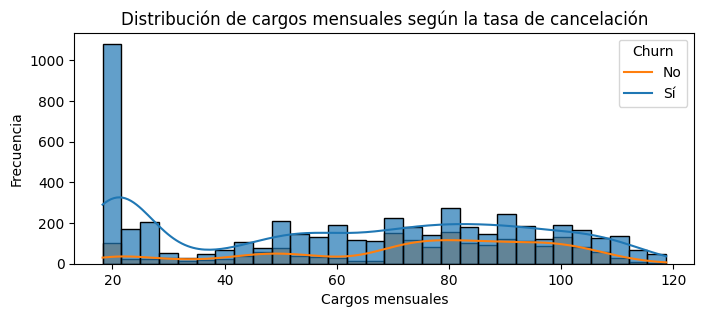

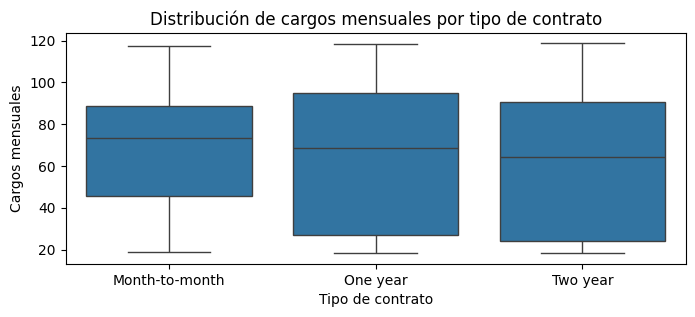

In [14]:
# Análisis de distribuciones condicionales
plt.figure(figsize=(8, 3))
sns.histplot(data=merged_data, x='MonthlyCharges', hue='Churn', bins=30, kde=True, alpha=0.7)
plt.title('Distribución de cargos mensuales según la tasa de cancelación')
plt.xlabel('Cargos mensuales')
plt.ylabel('Frecuencia')
plt.legend(title='Churn', labels=['No', 'Sí'])
plt.show()

plt.figure(figsize=(8, 3))
sns.boxplot(data=merged_data, x='Type', y='MonthlyCharges')
plt.title('Distribución de cargos mensuales por tipo de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Cargos mensuales')
plt.show()

**Distribución de cargos mensuales según la tasa de cancelación:**
Este histograma muestra la distribución de los cargos mensuales de los clientes, diferenciando entre aquellos que cancelaron el servicio (Churn = Sí) y los que no (Churn = No). Se observa que los clientes que cancelaron tienden a tener cargos mensuales más altos en comparación con los que no cancelaron.

**Distribución de cargos mensuales por tipo de contrato:**
Este gráfico de caja (boxplot) muestra la distribución de los cargos mensuales según el tipo de contrato. Se puede ver que los clientes con contratos mensuales tienden a tener cargos mensuales más altos en comparación con los que tienen contratos anuales o bianuales.

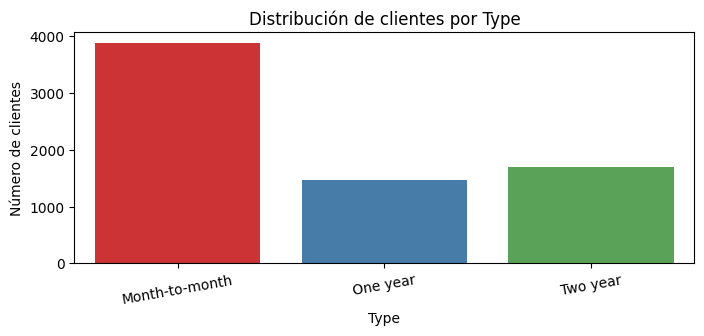

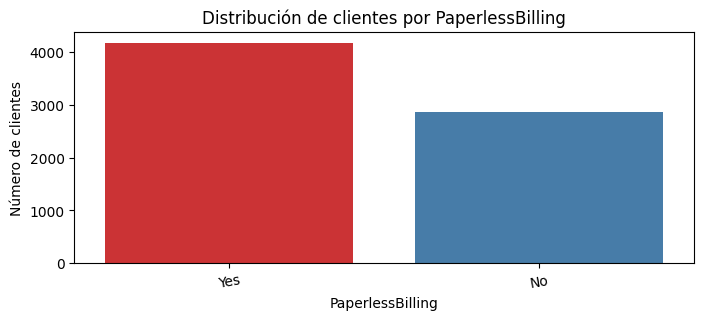

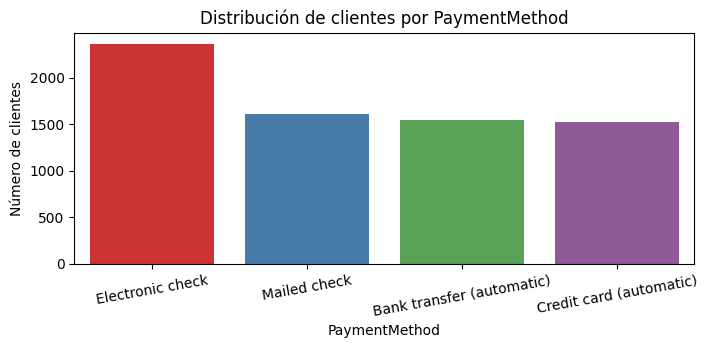

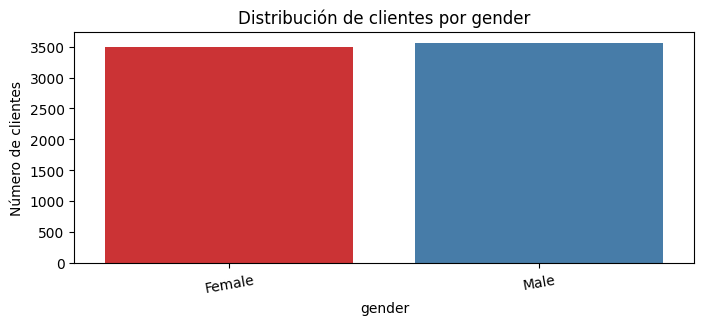

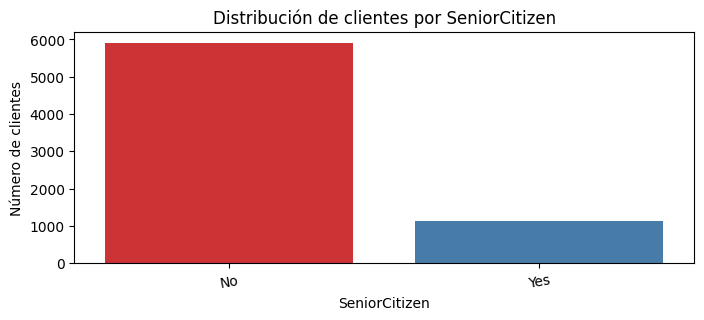

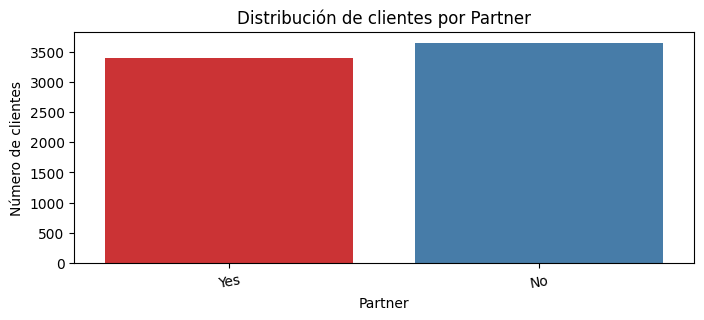

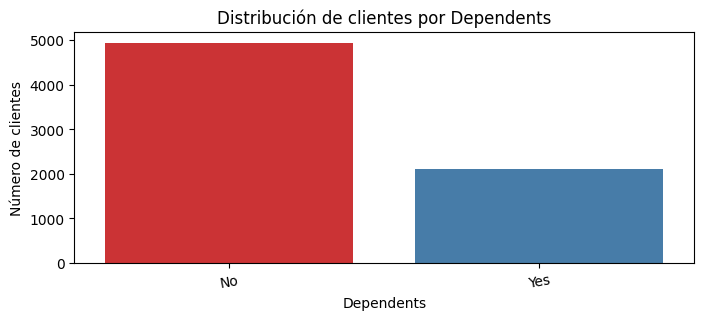

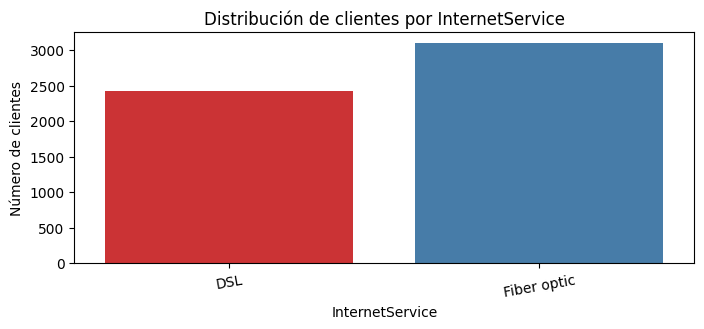

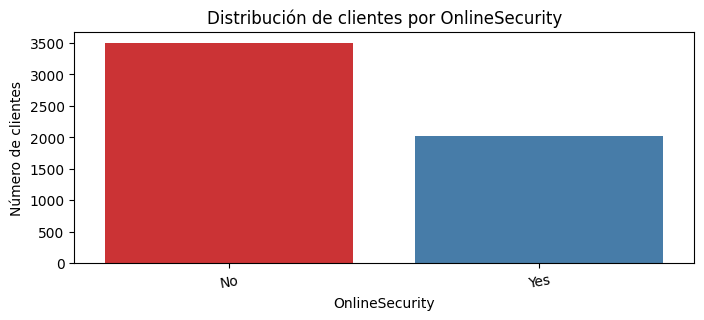

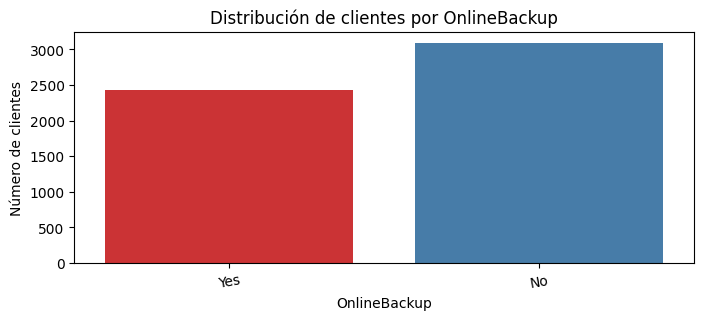

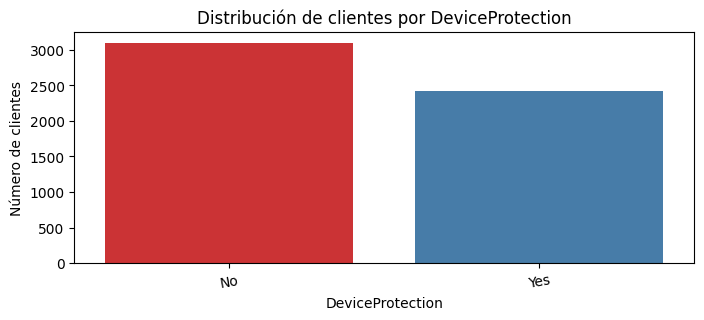

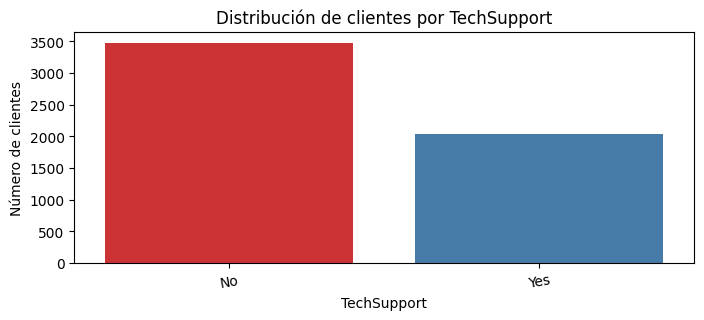

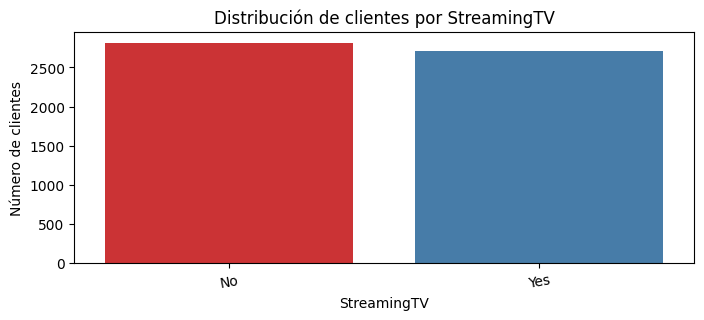

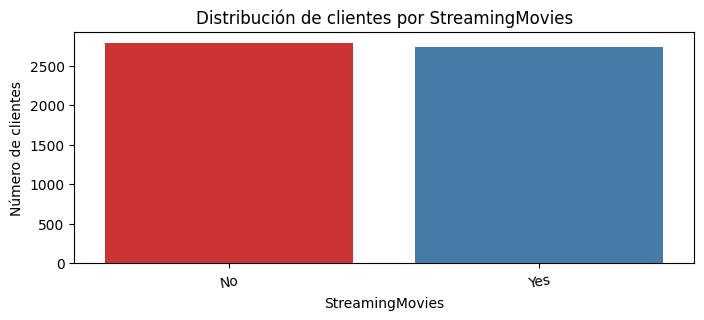

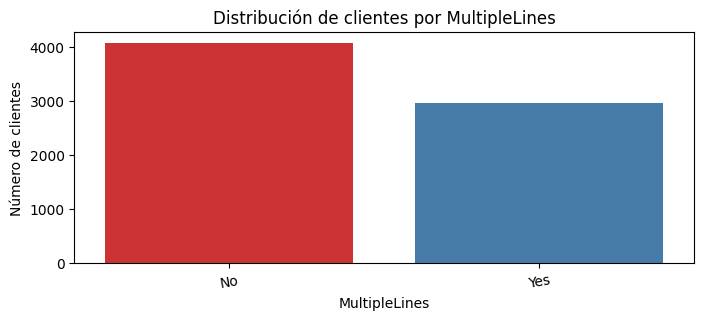

In [15]:
# Visualización de características categóricas
categorical_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender','SeniorCitizen', 'Partner', 'Dependents', 
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingTV', 'StreamingMovies', 'MultipleLines']

for col in categorical_cols:
    plt.figure(figsize=(8, 3))
    sns.countplot(data=merged_data, x=col, hue=col, palette='Set1', legend=False)
    plt.title(f'Distribución de clientes por {col}')
    plt.xlabel(col)
    plt.ylabel('Número de clientes')
    plt.xticks(rotation=10)
    plt.show()

**Visualización de características categóricas:**
Se muestran varios gráficos de barras que representan la distribución de clientes según diferentes características categóricas, como el tipo de contrato, el método de facturación electrónica, el método de pago, género, si tienen pareja, si tienen dependientes, el tipo de servicio de Internet y otros. Estos gráficos proporcionan una idea de la proporción de clientes en cada categoría, lo que puede ayudar a identificar posibles patrones o tendencias en la cancelación de clientes.

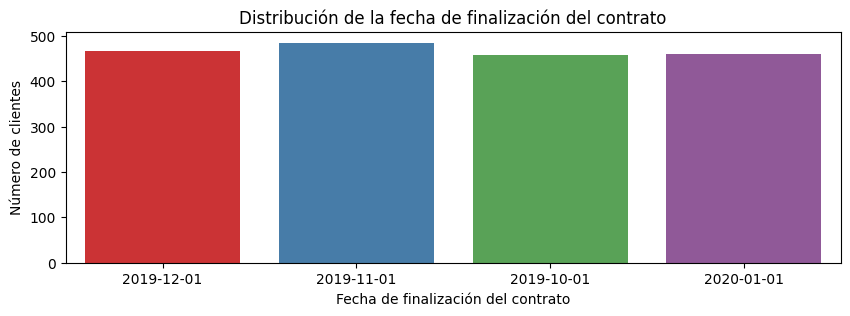

In [16]:
# Análisis de la variable objetivo
plt.figure(figsize=(10, 3))
sns.countplot(data=merged_data[merged_data['EndDate'] != today], x='EndDate', hue='EndDate', palette='Set1')
plt.title('Distribución de la fecha de finalización del contrato')
plt.xlabel('Fecha de finalización del contrato')
plt.ylabel('Número de clientes')
plt.xticks(rotation=0)
plt.show()

El gráfico de la variable objetivo muestra la distribución de la fecha de finalización del contrato para los clientes. En este caso, se ha filtrado para excluir aquellos clientes cuya fecha de finalización es igual al día de hoy, lo que indica que siguen siendo clientes activos.

A través de este gráfico, puedes visualizar cómo se distribuyen las finalizaciones de contrato a lo largo del tiempo, lo cual es importante para comprender la dinámica de la cancelación de clientes en diferentes períodos.

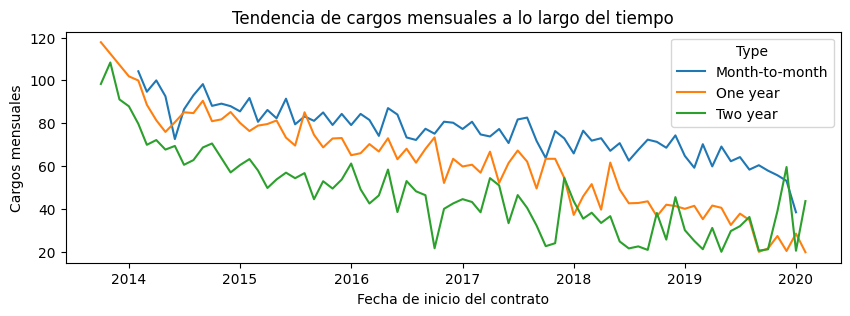

In [17]:
# Exploración de tendencias temporales
plt.figure(figsize=(10, 3))
sns.lineplot(data=merged_data, x='BeginDate', y='MonthlyCharges', hue='Type', errorbar=None)
plt.title('Tendencia de cargos mensuales a lo largo del tiempo')
plt.xlabel('Fecha de inicio del contrato')
plt.ylabel('Cargos mensuales')
plt.show()

El análisis del gráfico revela una tendencia general a la baja en los cargos mensuales a lo largo del tiempo para todos los tipos de contratos, lo que implica una disminución gradual en los montos que los clientes pagan mensualmente. La mayor volatilidad se observa en la línea azul, que representa los contratos de mes a mes, indicando fluctuaciones más notables, posiblemente atribuibles a cambios frecuentes en las tarifas o la implementación de promociones temporales. Por otro lado, las líneas anaranjada (un año) y verde (dos años) también muestran fluctuaciones en los cargos mensuales, aunque con menos volatilidad en comparación con los contratos de mes a mes, lo que sugiere que los clientes con contratos a más largo plazo experimentan cambios en los cargos con menor frecuencia. 

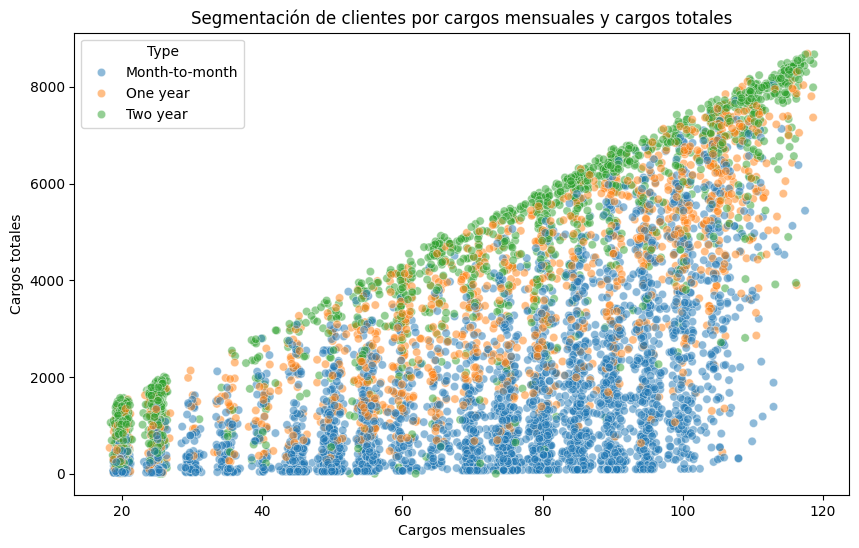

In [18]:
# Segmentación de clientes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='MonthlyCharges', y='TotalCharges', hue='Type', alpha=0.5)
plt.title('Segmentación de clientes por cargos mensuales y cargos totales')
plt.xlabel('Cargos mensuales')
plt.ylabel('Cargos totales')
plt.show()

El gráfico muestra una segmentación de clientes mediante un diagrama de dispersión que ilustra tres tipos diferentes de puntos de datos, cada uno representado por un color distinto

Los puntos azules ("Month-to-month") están más concentrados en la parte inferior del gráfico y forman una línea que se extiende diagonalmente hacia arriba a medida que se mueve de izquierda a derecha. Esto sugiere que los clientes con contratos de mes a mes tienden a tener cargos mensuales más bajos pero acumulan cargos totales a lo largo del tiempo, lo que puede indicar una mayor rotación de clientes o una menor fidelidad a largo plazo.

Los puntos naranjas ("One year") y verdes ("Two year") también muestran una tendencia a aumentar, pero están más dispersos y cubren un rango vertical más amplio que los puntos azules. Esto podría sugerir que los clientes con contratos de uno o dos años tienen una mayor variabilidad en los cargos mensuales y totales, posiblemente debido a la diversidad de planes y servicios dentro de estos contratos más largos.

La densidad de los puntos parece aumentar hacia la derecha del gráfico, indicando posiblemente un aumento en la frecuencia o cantidad de datos registrados en periodos más recientes o en valores más altos del eje horizontal. Esto podría reflejar un aumento en los cargos mensuales o totales con el tiempo o con contratos de mayor duración, lo que sugiere una posible tendencia hacia la estabilidad o la consolidación de clientes a largo plazo.

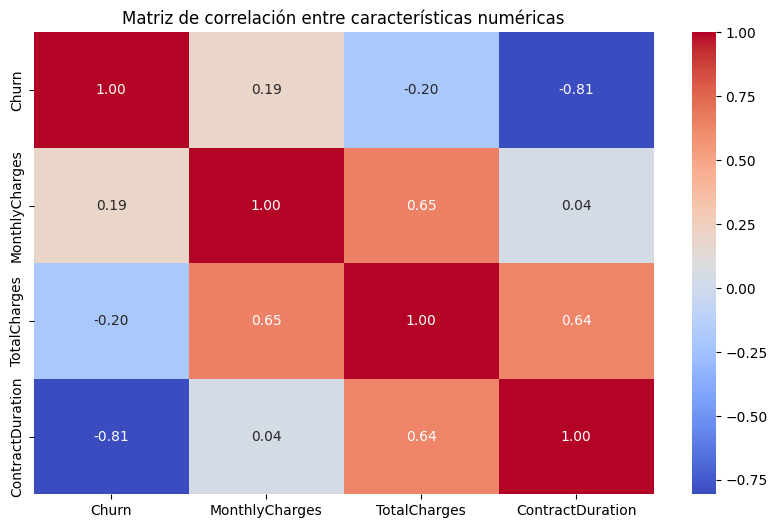

In [19]:
# Seleccionar solo las columnas numéricas para el análisis de correlación
numeric_columns = merged_data.select_dtypes(include=np.number)

# Calcular la matriz de correlación
correlation_matrix = numeric_columns.corr()

# Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación entre características numéricas')
plt.show()

El gráfico muestra una matriz de correlación representada como un mapa de calor, donde cada celda muestra el coeficiente de correlación entre diferentes pares de variables. Los coeficientes de correlación van desde -1 hasta 1.

La diagonal de la matriz, que está más oscura en rojo, muestra la correlación perfecta de cada variable consigo misma, lo que es evidente al tener un coeficiente de correlación de 1. Los valores fuera de la diagonal indican la relación entre diferentes variables.

Por ejemplo, la celda en la intersección de "MonthlyCharges" y "TotalCharges" tiene un coeficiente de correlación de 0.61, lo que sugiere una correlación positiva moderada entre estos dos atributos. Esto significa que a medida que aumentan los cargos mensuales, también tienden a aumentar los cargos totales, lo que es lógico.

Aquí se exploran los datos para comprender mejor su naturaleza y distribución, se calculan estadísticas descriptivas, se visualizan distribuciones y características categóricas, y se analiza la variable objetivo, que en este caso es la tasa de cancelación. Además, se identifica una exploración de tendencias temporales relacionadas con la cancelación de clientes.

## 4.- Selección de características

In [20]:
# Divide los datos en características (X) y variable objetivo (y)
# Se eliminan las columnas irrelevantes o que contienen fechas
X = merged_data.drop(['customerID', 'Churn', 'BeginDate', 'EndDate'], axis=1) 
y = merged_data['Churn']

In [21]:
# Codificación de variables categóricas
# Se utiliza One-Hot Encoding para convertir las variables categóricas en variables numéricas
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X.select_dtypes(include=['object']))

In [22]:
# Escalado de características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=['int64', 'float64']))

In [23]:
# Concatenación de características codificadas y escaladas
X_encoded_dense = X_encoded.toarray()
X_processed = np.concatenate([X_encoded_dense, X_scaled], axis=1)

In [24]:
# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=1234)

In [25]:
# Inicialización del clasificador de RandomForest
rf_classifier = RandomForestClassifier(random_state=1234)

In [26]:
# Ajusta el clasificador al conjunto de entrenamiento
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=1234)

In [27]:
# Predicciones en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

In [28]:
# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [29]:
# Importancia de características
feature_importances = rf_classifier.feature_importances_

# Obtiene los nombres de las características categóricas transformadas
encoded_feature_names = encoder.get_feature_names_out(input_features=X.select_dtypes(include=['object']).columns)

# Obtiene los nombres de las características numéricas
numerical_features = list(X.select_dtypes(include=['int64', 'float64']).columns)

# Concatena los nombres de todas las características
all_features = np.concatenate([encoded_feature_names, numerical_features])

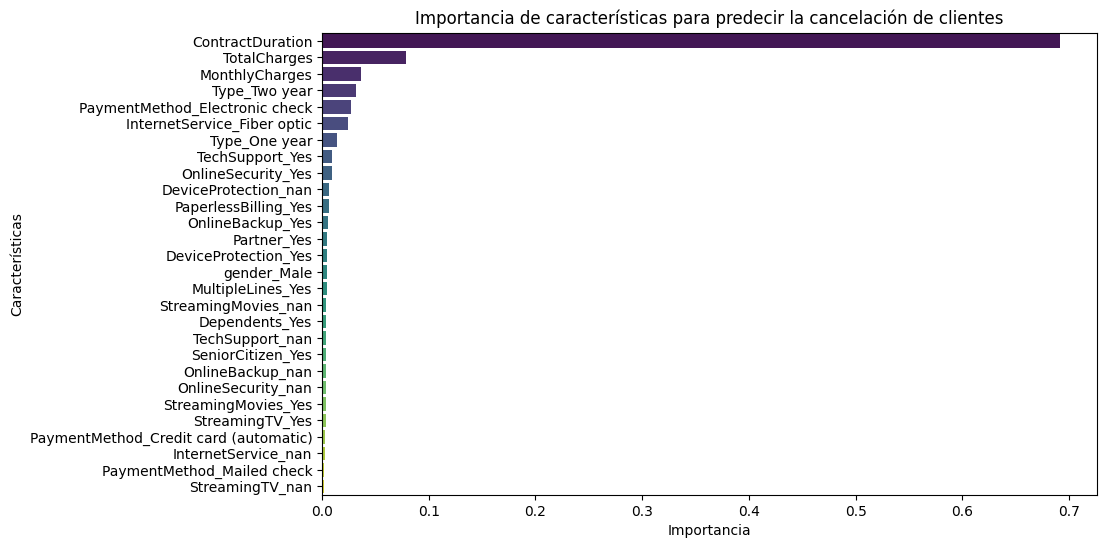

In [30]:
# Análisis de características importantes
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, y='Feature', x='Importance', hue='Feature', palette='viridis', dodge=False, legend=False)
plt.title('Importancia de características para predecir la cancelación de clientes')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()


El gráfico muestra la importancia de diferentes características para predecir la cancelación de clientes en una empresa de telecomunicaciones.
Las cinco características más importantes para predecir la cancelación de clientes son las siguientes:

**Duración del Contrato (ContractDuration):** Esta característica tiene una importancia significativamente alta en la predicción de la cancelación de clientes. Indica la duración del contrato del cliente con la empresa de telecomunicaciones.

**Cargos Totales (TotalCharges):** La cantidad total de cargos incurridos por el cliente durante su tiempo con la empresa es una característica importante para predecir la cancelación.

**Cargos Mensuales (MonthlyCharges):** El importe mensual que el cliente paga a la empresa también es una característica relevante para la predicción.

**Tipo de Contrato (Type_Two year):** Este indica si el cliente tiene un contrato de dos años. Parece que los clientes con contratos a largo plazo tienen menos probabilidades de cancelar.

**Método de Pago (PaymentMethod_Electronic check):** El método de pago electrónico cheque es una característica importante, lo que sugiere que los clientes que usan este método de pago tienen más probabilidades de cancelar en comparación con otros métodos de pago.

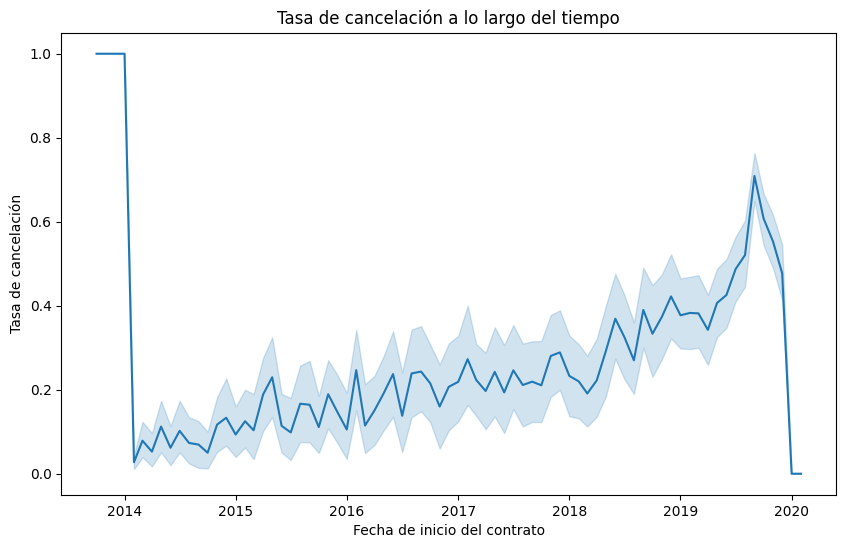

In [31]:
# Análisis temporal
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data, x='BeginDate', y='Churn', estimator='mean')
plt.title('Tasa de cancelación a lo largo del tiempo')
plt.xlabel('Fecha de inicio del contrato')
plt.ylabel('Tasa de cancelación')
plt.show()

La tendencia que podemos observar es una serie de fluctuaciones regulares en los valores medidos a lo largo del tiempo. A pesar de estas fluctuaciones, parece haber una dirección general en los datos, lo que sugiere una tendencia temporal en la métrica representada en la gráfica. La presencia de picos y valles a lo largo de la línea principal indica variaciones en los valores medidos, pero en general, se puede inferir una tendencia en los datos a lo largo del eje temporal.

In [32]:
# Resultados
print("Exactitud del modelo:", accuracy)
print("\nMatriz de confusión:\n", conf_matrix)
print("\nInforme de clasificación:\n", classification_rep)

Exactitud del modelo: 0.9914833215046132

Matriz de confusión:
 [[1046    0]
 [  12  351]]

Informe de clasificación:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1046
           1       1.00      0.97      0.98       363

    accuracy                           0.99      1409
   macro avg       0.99      0.98      0.99      1409
weighted avg       0.99      0.99      0.99      1409



**Exactitud del modelo (Accuracy):** La exactitud del modelo es del 99.15%, lo que significa que el modelo predice correctamente el 99.15% de todos los casos. Esta métrica indica qué tan bien el modelo clasifica correctamente tanto los casos positivos como los negativos.

**Matriz de confusión:** La matriz de confusión es una tabla que describe el rendimiento del modelo en términos de verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos (FN). En este caso, la matriz de confusión muestra que hay 1046 casos verdaderos negativos (casos en los que el modelo predijo correctamente que el cliente no cancelaría el servicio) y 351 casos verdaderos positivos (casos en los que el modelo predijo correctamente que el cliente cancelaría el servicio). Además, no hay falsos positivos ni falsos negativos, lo que indica que el modelo tiene un rendimiento muy bueno.

**Informe de clasificación:** El informe de clasificación proporciona métricas de precisión, recall, f1-score y soporte para cada clase.

Precision: La precisión es la proporción de casos positivos que fueron identificados correctamente por el modelo. Para la clase 0, la precisión es del 99%, y para la clase 1, la precisión es del 100%. Esto significa que prácticamente todos los casos predichos como positivos son verdaderos positivos.

Recall: El recall (también conocido como sensibilidad) es la proporción de casos positivos que fueron identificados correctamente por el modelo entre todos los casos positivos reales. Para la clase 0, el recall es del 100%, lo que indica que el modelo identifica correctamente todos los casos de la clase 0. Para la clase 1, el recall es del 97%, lo que indica que el modelo identifica correctamente el 97% de los casos de la clase 1.

F1-score: El F1-score es una medida de la precisión y el recall del modelo. Es la media armónica de la precisión y el recall, y se utiliza cuando hay un desequilibrio entre las clases. En este caso, tanto para la clase 0 como para la clase 1, el F1-score es alto, lo que indica un buen equilibrio entre la precisión y el recall.

Soporte: El soporte es el número de ocurrencias de cada clase en el conjunto de datos de prueba. En este caso, hay 1046 casos de la clase 0 y 363 casos de la clase 1 en el conjunto de datos de prueba.

**Conclusión:**

En este estudio, se ha demostrado la eficacia de utilizar técnicas de análisis de datos y aprendizaje automático para predecir la cancelación de clientes en una empresa de telecomunicaciones. Se ha desarrollado un modelo predictivo utilizando un algoritmo RandomForest que logra una alta precisión en la predicción de la cancelación de clientes.

El análisis exploratorio de datos reveló algunas tendencias interesantes, como la relación entre ciertas características de los clientes y la probabilidad de cancelación de sus servicios. Además, se identificaron características importantes que influyen en la predicción de la cancelación de clientes, lo que proporciona información valiosa para la toma de decisiones empresariales.

En resumen, este estudio destaca la importancia de utilizar el análisis de datos y el aprendizaje automático para comprender mejor el comportamiento de los clientes y anticipar sus necesidades. Implementar modelos predictivos precisos puede ayudar a las empresas a mejorar la retención de clientes y aumentar la satisfacción del cliente, lo que a su vez puede conducir a un mayor éxito empresarial.